In [1]:
%matplotlib notebook

In [2]:
from importlib import reload
from typing import Dict, Tuple, List, Union

import numpy as np
from matplotlib import pyplot as plt

In [3]:
import qcodes as qc
from qcodes.instrument.base import Instrument, InstrumentBase
from qcodes.instrument.parameter import Parameter, ArrayParameter

from pytopo.qctools.instruments import create_inst

In [4]:
class ArrayStorage(ArrayParameter):
    
    def __init__(self, *arg, **kw):
        self._data = kw.pop('data', np.array([]))
        kw['shape'] = self._data.shape
        super().__init__(*arg, **kw)
        
    def get_raw(self):
        return self._data

    
class DynamicDataArray(ArrayParameter):
    
    def __init__(self, name, **kw):
        self.get_data_method = kw.pop('get_data_method')
        super().__init__(name, **kw)
    
    def get_raw(self):
        return self.get_data_method()


class HardSweep(Instrument):
    
    def __init__(self, name: str, **kw):
        super().__init__(name, **kw)
        self._meta_attrs = ['sweep_dims'] # , 'sweep_vals']
        
    def set_sweep_dims(self, sweeps: Dict[str, Union[List, np.ndarray]], units=None):
        self.sweep_dims = []
        self.sweep_vals = []
        self.sweep_shape = []        
        for n, v in sweeps.items():
            self.sweep_dims.append(n)
            self.sweep_vals.append(v)
            self.sweep_shape.append(len(v))
            
        if units is not None:
            self.sweep_units = units
        else:
            self.sweep_units = ['' for s in self.sweep_dims]
        self.sweep_shape = tuple(self.sweep_shape)
        self.sweep_grids = np.meshgrid(*self.sweep_vals, indexing='ij')
        
        self.sweep_params = []
        for i, n in enumerate(self.sweep_dims):
            self.add_parameter(n, parameter_class=ArrayStorage, 
                               data=self.sweep_grids[i].reshape(-1),
                               unit=self.sweep_units[i])
            _p = getattr(self, n)
            self.sweep_params.append(_p)
    
    def setup(self):
        raise NotImplementedError
    
    def get_sweep_coord_zip(self):
        return list(zip(*[s.reshape(-1) for s in self.sweep_grids]))
    
    def get_sweep_coords(self):
        return list(zip(self.sweep_params, [s.reshape(-1) for s in self.sweep_grids]))
        

class HardSweepDetector(Instrument):
    
    def __init__(self, name: str, **kw):
        sweeper = kw.pop('sweeper', None)
        super().__init__(name, **kw)
        self.set_sweeper(sweeper)
        
    def set_sweeper(self, swp):
        self.sweeper = swp
        
    def setup(self):
        raise NotImplementedError

In [5]:
class HardRabi(HardSweep):
    
    def __init__(self, name: str, **kw):
        super().__init__(name, **kw)
        
        self.add_parameter('start_amp', get_cmd=None, set_cmd=None,
                           unit='a.u.', initial_value=0)
        self.add_parameter('stop_amp', get_cmd=None, set_cmd=None,
                           unit='a.u.', initial_value=1)
        self.add_parameter('amp_points',get_cmd=None, set_cmd=None,
                           unit='', initial_value=11)
        
        self.add_parameter('start_det', get_cmd=None, set_cmd=None,
                           unit='Hz', initial_value=-1)
        self.add_parameter('stop_det', get_cmd=None, set_cmd=None,
                           unit='Hz', initial_value=1)
        self.add_parameter('det_points', get_cmd=None, set_cmd=None,
                           unit='', initial_value=11)
        
    def setup(self):
        self.set_sweep_dims(dict(amplitude=np.linspace(self.start_amp(), self.stop_amp(), self.amp_points()),
                                 detuning=np.linspace(self.start_det(), self.stop_det(), self.det_points())),
                            units=[self.start_amp.unit, self.start_det.unit])
        
    def get_dummy_data(self, tvals):
        if type(tvals) not in [list, np.ndarray]:
            tvals = [tvals]
        
        def p(det, amp):
            fr = amp**2 / (det**2 + amp**2)
            return fr * np.cos((det**2 + amp**2)**.5)**2.
        
        p0 = p(self.detuning(), self.amplitude())
        data = np.zeros((p0.size, len(tvals)))
        data = np.outer(p0, np.exp(-tvals))
        return data
        
        
class DummyTimeDomainDetector(HardSweepDetector):
    
    def get_td_data(self):
        tvals = np.linspace(self.start_time(), self.stop_time(), self.time_points())
        data = self.sweeper.get_dummy_data(tvals).mean(axis=-1)
        return data
    
    def __init__(self, name, **kw):
        super().__init__(name, **kw)
        
        self.add_parameter('start_time', get_cmd=None, set_cmd=None, unit='ns', initial_value=0)
        self.add_parameter('stop_time', get_cmd=None, set_cmd=None, unit='ns', initial_value=10)
        self.add_parameter('time_points', get_cmd=None, set_cmd=None, initial_value=11)
        
    def setup(self):
        shape = self.sweeper.sweep_shape
        self.add_parameter('data', parameter_class=DynamicDataArray, unit='a.u.', 
                           shape=shape, get_data_method=self.get_td_data)

In [6]:
rabi_swp = create_inst(HardRabi, 'rabi_swp', force_new_instance=True)
det = create_inst(DummyTimeDomainDetector, name='td_detector', force_new_instance=True)
station = qc.Station(rabi_swp, det)

C:\Users\wopfa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


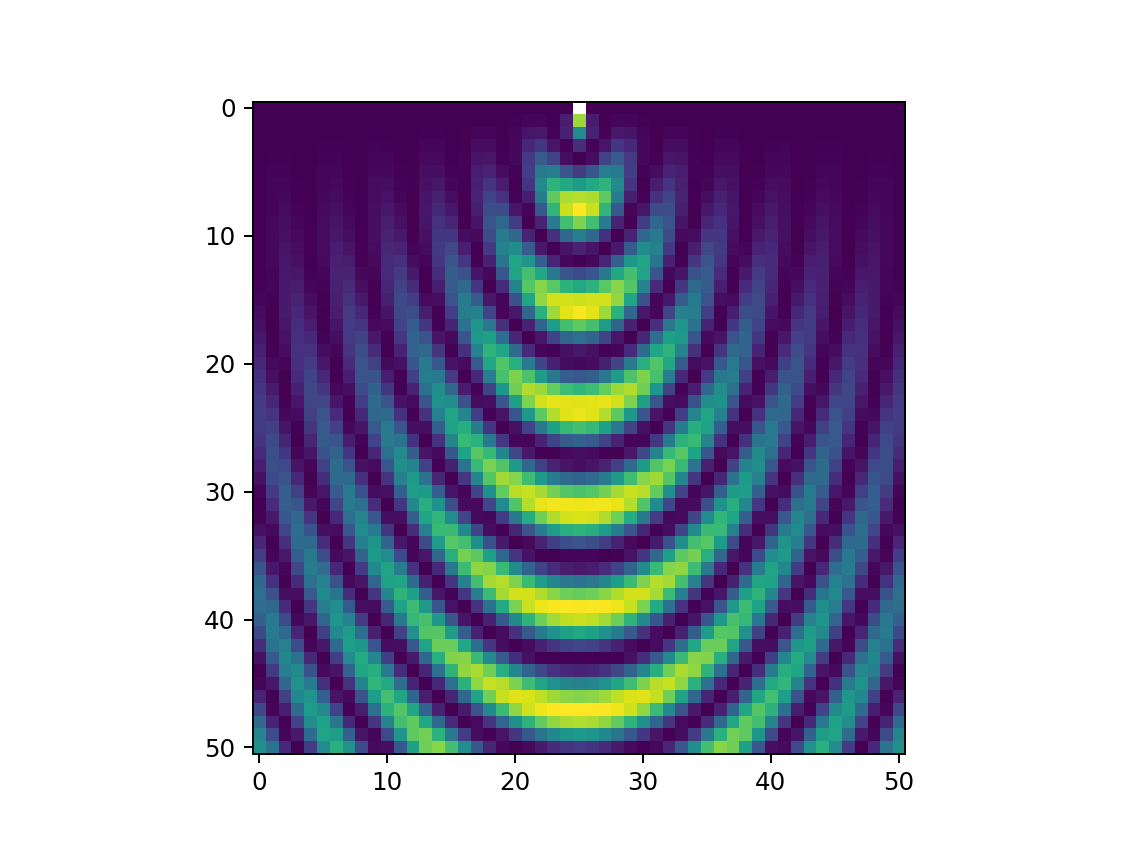

In [7]:
rabi_swp.start_amp(0)
rabi_swp.stop_amp(20)
rabi_swp.amp_points(51)
rabi_swp.start_det(-20)
rabi_swp.stop_det(20)
rabi_swp.det_points(51)
rabi_swp.setup()

det.set_sweeper(rabi_swp)
det.setup()
data = det.data()

fig, ax = plt.subplots(1,1)
ax.imshow(data.reshape(rabi_swp.sweep_shape))

In [8]:
station.snapshot()

{'components': {},
 'default_measurement': [],
 'instruments': {'rabi_swp': {'__class__': '__main__.HardRabi',
   'functions': {},
   'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.Parameter',
     'full_name': 'rabi_swp_IDN',
     'instrument': '__main__.HardRabi',
     'instrument_name': 'rabi_swp',
     'inter_delay': 0,
     'label': 'IDN',
     'name': 'IDN',
     'post_delay': 0,
     'raw_value': {'firmware': None,
      'model': 'rabi_swp',
      'serial': None,
      'vendor': None},
     'ts': '2018-05-23 17:29:57',
     'unit': '',
     'vals': '<Anything>',
     'value': {'firmware': None,
      'model': 'rabi_swp',
      'serial': None,
      'vendor': None}},
    'amp_points': {'__class__': 'qcodes.instrument.parameter.Parameter',
     'full_name': 'rabi_swp_amp_points',
     'instrument': '__main__.HardRabi',
     'instrument_name': 'rabi_swp',
     'inter_delay': 0,
     'label': 'amp_points',
     'name': 'amp_points',
     'post_delay': 0,
     'raw_